In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import ast
import json
import sys
sys.path.insert(0, '../PSA/')
from books_product_info import BooksProductInfoExtractor
from langchain_community.chat_models import ChatOpenAI
from langchain.prompts import PromptTemplate

## (일단 접어둠)

In [2]:
# open the jsonl file
df = pd.read_json('meta_with_reviews_5core_10pct.jsonl', lines=True)
print("Shape of the test DataFrame:", df.shape)
print("Columns in the test DataFrame:", df.columns)
print("First 3 rows of the test DataFrame:", "\n", df.head(3))

Shape of the test DataFrame: (49506, 17)
Columns in the test DataFrame: Index(['main_category', 'title', 'subtitle', 'author', 'average_rating',
       'rating_number', 'features', 'description', 'price', 'images', 'videos',
       'store', 'categories', 'details', 'parent_asin', 'bought_together',
       'reviews'],
      dtype='object')
First 3 rows of the test DataFrame: 
   main_category                                              title  \
0         Books                    Whistle: A New Gotham City Hero   
1         Books  Adobe Premiere Pro CC: Visual Quickstart Guide...   
2  Buy a Kindle                   Deadlocked 3 (Deadlocked Series)   

                                     subtitle  \
0  Paperback – Illustrated, September 7, 2021   
1                             Pap/Psc Edition   
2                              Kindle Edition   

                                              author  average_rating  \
0  {'avatar': 'https://m.media-amazon.com/images/...             4.4   

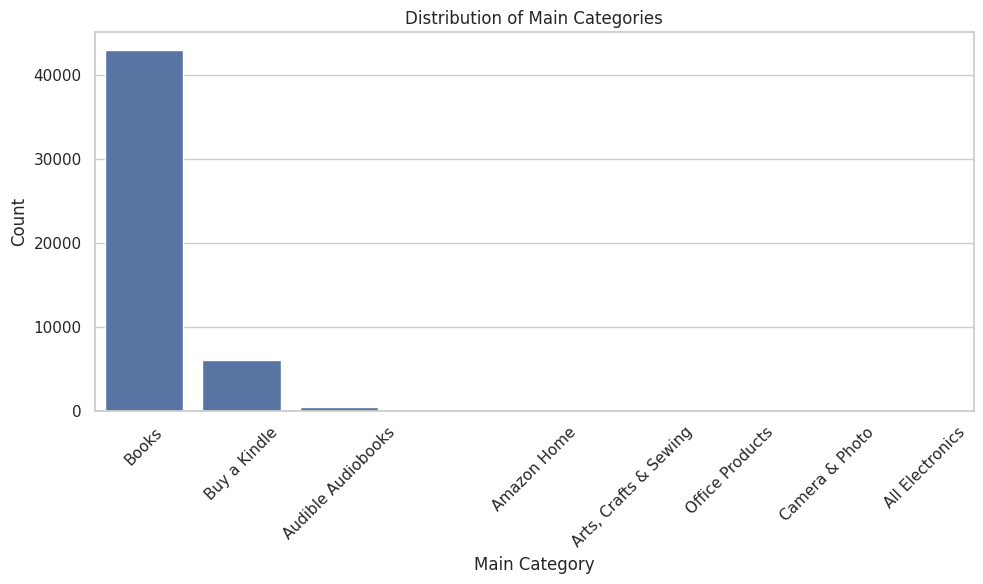

In [7]:
# distribution of main_category values
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='main_category', order=df['main_category'].value_counts().index)
plt.title('Distribution of Main Categories')
plt.xlabel('Main Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [9]:
df['main_category'].value_counts()

main_category
Books                    42898
Buy a Kindle              6094
Audible Audiobooks         468
                            34
Amazon Home                  3
Arts, Crafts & Sewing        2
Office Products              2
Camera & Photo               1
All Electronics              1
Name: count, dtype: int64

In [87]:
# leave 'Books' only
df_books = df[df['main_category'] == 'Books'].copy()
print("Shape of the Books DataFrame:", df_books.shape)
print("Columns in the Books DataFrame:", df_books.columns)
print("First 3 rows of the Books DataFrame:", "\n", df_books.head(3))

Shape of the Books DataFrame: (42898, 17)
Columns in the Books DataFrame: Index(['main_category', 'title', 'subtitle', 'author', 'average_rating',
       'rating_number', 'features', 'description', 'price', 'images', 'videos',
       'store', 'categories', 'details', 'parent_asin', 'bought_together',
       'reviews'],
      dtype='object')
First 3 rows of the Books DataFrame: 
   main_category                                              title  \
0         Books                    Whistle: A New Gotham City Hero   
1         Books  Adobe Premiere Pro CC: Visual Quickstart Guide...   
3         Books                                             Slider   

                                     subtitle  \
0  Paperback – Illustrated, September 7, 2021   
1                             Pap/Psc Edition   
3              Hardcover – September 12, 2017   

                                              author  average_rating  \
0  {'avatar': 'https://m.media-amazon.com/images/...             4.4

In [88]:
df_books.reset_index(drop=True, inplace=True)

In [89]:
# store the DataFrame to a new jsonl file
with open('meta_with_reviews_5core_10pct_booksOnly.jsonl', 'w') as fout:
    for record in df_books.to_dict(orient='records'):
        fout.write(json.dumps(record) + '\n')

In [2]:
# open the new jsonl file
df_books = pd.read_json('meta_with_reviews_5core_10pct_booksOnly.jsonl', lines=True)

### Extract Product Card

In [304]:
df_books['parent_asin']

0        1401293220
1        0321929543
2        0763690708
3        0786931663
4        0865652961
            ...    
42893    0312366574
42894    1413753795
42895    1250861829
42896    1998805255
42897    1577344677
Name: parent_asin, Length: 42898, dtype: object

## Product Card 추출 코드

In [3]:
def _author_extractor(row):
    """
    Extracts the author name from the row and returns it as a string.
    If 'author' is a dict, it extracts the 'name' key.
    If 'author' is None, it attempts to extract from 'store'.
    """
    if isinstance(row['author'], dict):
        return row['author']['name']
    elif row['author'] is None and isinstance(row['store'], str):
        possibly_multiple = row['store'].split(',')
        for i in range(len(possibly_multiple)):
            possibly_multiple[i] = possibly_multiple[i].strip()
            if '(Author)' in possibly_multiple[i]:
                possibly_multiple[i] = possibly_multiple[i].split('(Author)')[0].strip()
        return ', '.join(possibly_multiple)
    else:
        return "None"
    
def _categories_extractor(row):
    categories = []
    if isinstance(row['categories'], list) and len(row['categories']) > 0:
        for cat in row['categories']:
            if cat != 'Books':
                categories.append(cat)
        return ', '.join(categories)
    else:
        return "None"

def _publish_extractor(row):
    if isinstance(row['details'], dict) and 'Publisher' in row['details']:
        return row['details']['Publisher'].strip()
    else:
        return "None"

def _avg_rating_extractor(row):
    """
    Extracts the average rating from the row. 
    Average rating is expected to be a float.
    For BM25 indexing, we will transform the float to a string,
    which signifies a range (a, b], for instance, "rating_4.3_4.5" means (4.3, 4.5].
    Looking at the distribution, we will set under 4.3 / 4.3-4.5 / 4.5-4.7 / 4.7-5.0
    """
    raw_float = row['average_rating']
    if isinstance(raw_float, float):
        if raw_float < 4.3:
            return "rating_0_4.3"
        elif 4.3 <= raw_float < 4.5:
            return "rating_4.3_4.5"
        elif 4.5 <= raw_float < 4.7:
            return "rating_4.5_4.7"
        elif 4.7 <= raw_float <= 5.0:
            return "rating_4.7_5.0"
        else:
            return "None"
    else:
        return "None"

def _price_extractor(row):
    """
    Extracts the price from the row.
    We only consider the case where 'price' is a float.
    If 'price' is None or not a float, we return "None".
    For BM25 indexing, we will transform the float to a string,
    which signifies a range (a, b], for instance, "price_0_10" means (0, 10].
    Looking at the distribution, we will set under 5 / 5-10 / 10-15 / 15-20 / 20+
    """
    if isinstance(row['price'], float):
        if row['price'] < 5:
            return "price_0_5"
        elif 5 <= row['price'] < 10:
            return "price_5_10"
        elif 10 <= row['price'] < 15:
            return "price_10_15"
        elif 15 <= row['price'] < 20:
            return "price_15_20"
        else:
            return "price_20_plus"
    else:
        return "None"

PRODUCT_CARD_PROMPT = PromptTemplate(
    input_variables=["item"],
    template=(
        "You are an expert product information extractors. You are now working on a product card for a book sold on Amazon."
        "The product card will be used for product search, indexed by BM25."
        "Considering that BM25 is a text-based search algorithm, the product card should be concise (usually noun phrases) and informative; you should be careful with the word choice."
        "You may give several noun phrases for each field, separated by commas."
        "Given the following product metadata and user reviews on the product, extract the useful product information and transform it into a concise product card with the following fields:"
        "target audience: who this book is best suited for,"
        "key concepts: 3-5 core features or topics of the book (3-5 noun phrases),"
        "style: writing style of the book(e.g., academic, narrative, technical, etc.),"
        "tone: tone of the book (e.g., formal, informal, friendly, etc.),"
        "mood: the feeling, atmosphere, or ambiance conveyed by the book (e.g., suspenseful, uplifting, etc.); this is optional for creative books such as fiction, essay,"
        "review pros: 3-5 positive aspects of the book based on user reviews,"
        "review cons: 3-5 negative aspects of the book based on user reviews,"
        "\n"
        "Format your response as a JSON object with the following fields:" \
        "\n"
        "target_audience, key_concepts, style, tone, mood, review_pros, review_cons\n"
        "\n---\n"
        "Product metadata including reviews:\n{item}\n\n"
    )
)

def _llm_extractor(llm, row):
    prompt = PRODUCT_CARD_PROMPT.format(item=row.to_dict())
    print(prompt)
    response = llm.invoke(prompt).content.strip()
    try:
        response_json = json.loads(response)
        return response_json.get('key_concepts'), response_json.get('target_audience'), \
               response_json.get('style'), response_json.get('tone'), \
                response_json.get('mood'), response_json.get('review_pros'), \
                response_json.get('review_cons')
    except json.JSONDecodeError:
        print("Error decoding JSON response:", response)
        return "None", "None", "None", "None", "None", "None", "None"

def naive_product_card_extractor(llm, row) -> dict:
    """
    Extracts product information from a row of the DataFrame.
    This function returns a dictionary-format product card.
    """
    title = row['title']
    pid = row['parent_asin']
    author = _author_extractor(row)
    categories = _categories_extractor(row)
    key_concepts, target_audience, style, tone, mood, review_pros, review_cons = _llm_extractor(llm, row)
    publish = _publish_extractor(row)
    avg_rating = _avg_rating_extractor(row)
    price = _price_extractor(row)
    return {
        'pid': pid,
        'title': title,
        'author': author,
        'categories': categories,
        'key_concepts': key_concepts,
        'target_audience': target_audience,
        'style': style,
        'tone': tone,
        'mood': mood,
        'review_pros': review_pros,
        'review_cons': review_cons,
        'publish': publish,
        'avg_rating_range': avg_rating,
        'price_range': price
    }

def stringify_extracted(product_card: dict) -> dict:
    """
    Converts the extracted product card into a dictionary that contains string-format product card for BM25 indexing.
    """
    pid = product_card.get('pid', 'None')
    title = "title: " + product_card.get('title', 'None')
    author = "author: " + product_card.get('author', 'None')
    categories = "categories: " + product_card.get('categories', 'None')
    key_concepts = "key_concepts: " + product_card.get('key_concepts', 'None')
    target_audience = "target_audience: " + product_card.get('target_audience', 'None')
    style = "style: " + product_card.get('style', 'None')
    tone = "tone: " + product_card.get('tone', 'None')
    mood = "mood: " + product_card.get('mood', 'None')
    review_pros = "review_pros: " + product_card.get('review_pros', 'None')
    review_cons = "review_cons: " + product_card.get('review_cons', 'None')
    publish = "publish: " + product_card.get('publish', 'None')
    avg_rating = "avg_rating_range: " + product_card.get('avg_rating_range', 'None')
    price = "price_range: " + product_card.get('price_range', 'None')

    blob = "\n".join([title, author, categories, key_concepts, target_audience, style, tone, mood, review_pros, review_cons, publish, avg_rating, price])

    return { "id": pid, "product_card": blob}
    

### 그냥 임의의 데이터에 대해서 실시하려면 이것대로 하면 됩니다 (아래 예시)
### api-key가 없기 때문에 넣거나 따로 설정하셔야 합니다.

In [ ]:
llm = ChatOpenAI(model_name="gpt-4.1-nano", api_key="")
product_card = naive_product_card_extractor(llm, test_row)
stringified_product_card = stringify_extracted(product_card)
print("Extracted product card:\n", stringified_product_card['product_card'])

You are an expert product information extractors. You are now working on a product card for a book sold on Amazon.The product card will be used for product search, indexed by BM25.Considering that BM25 is a text-based search algorithm, the product card should be concise (usually noun phrases) and informative; you should be careful with the word choice.You may give several noun phrases for each field, separated by commas.Given the following product metadata and user reviews on the product, extract the useful product information and transform it into a concise product card with the following fields:target audience: who this book is best suited for,key concepts: 3-5 core features or topics of the book (3-5 noun phrases),style: writing style of the book(e.g., academic, narrative, technical, etc.),tone: tone of the book (e.g., formal, informal, friendly, etc.),mood: the feeling, atmosphere, or ambiance conveyed by the book (e.g., suspenseful, uplifting, etc.); this is optional for creative 

In [10]:
# count the number of words
def count_words(text):
    if isinstance(text, str):
        return len(text.split())
    else:
        return 0
    
mytext = """
title: No Strangers Here: A Riveting Dark Irish Mystery (A County Kerry Novel)
author: Carlene O'Connor
categories: Mystery, Thriller & Suspense, Thrillers & Suspense
key_concepts: Irish village setting, murder mystery, family secrets, small-town intrigue, detective investigation
target_audience: fans of Irish mysteries, readers of cozy and dark crime novels, mystery enthusiasts interested in Irish settings, fans of detective fiction, readers of atmospheric thrillers
style: atmospheric, character-driven, plot-twisting, descriptive, suspenseful
tone: dark, compelling, immersive, serious, slightly humorous at times
mood: intriguing, suspenseful, mysterious, brooding, atmospheric
review_pros: rich Irish setting, engaging plot twists, well-developed characters, atmospheric storytelling, compelling mysteries
review_cons: some found the plot convoluted, pacing can be slow, not as cozy as traditional mysteries, occasional complexity may confuse readers, some reviews mention disappointing or confusing elements
publish: Kensington (October 25, 2022)
avg_rating: rating_4.3_4.5
price: price_20_plus
"""

print(count_words(mytext))



133


In [305]:
SYSTEM_PROMPT = PromptTemplate(
    input_variables=[],
    template=(
        "You are an expert product information extractors. You are now working on a product card for a book sold on Amazon."
        "The product card will be used for product search, indexed by BM25."
        "Considering that BM25 is a text-based search algorithm, the product card should be concise (usually noun phrases) and informative; you should be careful with the word choice."
        "You may give several noun phrases for each field, separated by commas."
        "Given the following product metadata and user reviews on the product, extract the useful product information and transform it into a concise product card with the following fields:"
        "target audience: who this book is best suited for,"
        "key concepts: 3-5 core features or topics of the book (3-5 noun phrases),"
        "style: writing style of the book(e.g., academic, narrative, technical, etc.),"
        "tone: tone of the book (e.g., formal, informal, friendly, etc.),"
        "mood: the feeling, atmosphere, or ambiance conveyed by the book (e.g., suspenseful, uplifting, etc.); this is optional for creative books such as fiction, essay,"
        "review pros: 3-5 positive aspects of the book based on user reviews,"
        "review cons: 3-5 negative aspects of the book based on user reviews,"
        "\n"
        "Format your response as a JSON object with the following fields:" \
        "\n"
        "target_audience, key_concepts, style, tone, mood, review_pros, review_cons\n"
        "You should not include any other information in the response."
    )
)

PRODUCT_CARD_PROMPT = PromptTemplate(
    input_variables=["item"],
    template=(
        "Product metadata including reviews for product card extraction:\n{item}\n\n"
    )
)

# we iterate the rows of the dataframe and pre-generate the messages
# the messages will be used for the text generation pipeline
# messages are written to a jsonl file

with open('messages.jsonl', 'w') as fout:
    for _, row in df_books.iterrows():
        system_prompt = SYSTEM_PROMPT.format()
        user_prompt = PRODUCT_CARD_PROMPT.format(item=row.to_dict())
        messages = [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt}
        ]
        messages_with_pid = {
            'pid': row.get('parent_asin'),
            'messages': messages
        }
        fout.write(json.dumps(messages_with_pid) + '\n')

# ----- message prep done -----

# let's run the pipeline on the pre-generated messages, row by row

# with open('messages.jsonl', 'r') as fin:
#     # read the message by each line
#     for line in fin:
#         message = json.loads(line)
#         pipe = pipeline(
#             "text-generation",
#             model=model_id,
#             torch_dtype=torch.bfloat16,
#             device_map="auto",
#             token=hf_token
#         )
#         outputs = pipe(
#             message,
#             max_new_tokens=1000
#         )
#         print(outputs[0]["generated_text"][-1])
#         break

# import time
# start = time.time()
# outputs = pipe(
#     messages,
#     max_new_tokens=100,
# )
# end = time.time()
# print(f"Time taken: {end - start} seconds")
# print(outputs[0]["generated_text"][-1])


## 실제로 사용한 방법(별도 llm에서 만들어온 product card 일부 내용을 읽어들여서 combine)

In [27]:
product_cards = {}
with open("product_card_llama_refined.jsonl", "r") as infile:
    for line in infile:
        data = json.loads(line)
        pid = data["pid"]
        product_cards[pid] = data['product_card']

In [4]:
def _llm_extracted_product_card_parser(pid):
    product_card = product_cards.get(pid)
    product_card = json.loads(product_card)
    return (
        str(product_card.get('key_concepts', 'None')),
        str(product_card.get('target_audience', 'None')),
        str(product_card.get('style', 'None')),
        str(product_card.get('tone', 'None')),
        str(product_card.get('mood', 'None')),
        str(product_card.get('review_pros', 'None')),
        str(product_card.get('review_cons', 'None'))
    )

def product_card_extractor(row) -> dict:
    """
    Extracts product information from a row of the DataFrame.
    This function returns a dictionary-format product card.
    """
    title = row['title']
    pid = row['parent_asin']
    author = _author_extractor(row)
    categories = _categories_extractor(row)
    key_concepts, target_audience, style, tone, mood, review_pros, review_cons = _llm_extracted_product_card_parser(pid)
    publish = _publish_extractor(row)
    avg_rating = _avg_rating_extractor(row)
    price = _price_extractor(row)
    return {
        'pid': pid,
        'title': title,
        'author': author,
        'categories': categories,
        'key_concepts': key_concepts,
        'target_audience': target_audience,
        'style': style,
        'tone': tone,
        'mood': mood,
        'review_pros': review_pros,
        'review_cons': review_cons,
        'publish': publish,
        'avg_rating_range': avg_rating,
        'price_range': price
    }

In [8]:
# open the new jsonl file
df_books = pd.read_json('meta_with_reviews_5core_10pct_booksOnly.jsonl', lines=True)

In [28]:
excluded = 0
excluded_rows = set()
with open('product_card_llama_final.jsonl', 'w') as fout:
    for _, row in df_books.iterrows():
        try:
            product_card = product_card_extractor(row)
            stringified_product_card = stringify_extracted(product_card)
            fout.write(json.dumps(stringified_product_card) + '\n')
        except Exception as e:
            print(f"Error processing row {_}: {e}")
            excluded += 1
            excluded_rows.add(row['parent_asin'])
            continue

print(f"Total rows excluded due to errors: {excluded}")

Error processing row 35: Unterminated string starting at: line 3 column 19 (char 127)
Error processing row 330: Unterminated string starting at: line 5 column 11 (char 689)
Error processing row 490: Unterminated string starting at: line 99 column 5 (char 4506)
Error processing row 518: 'name'
Error processing row 1061: Expecting ',' delimiter: line 8 column 216 (char 937)
Error processing row 1525: Expecting ',' delimiter: line 8 column 129 (char 656)
Error processing row 2005: Unterminated string starting at: line 8 column 18 (char 1889)
Error processing row 2484: Expecting ',' delimiter: line 8 column 50 (char 664)
Error processing row 2561: Expecting value: line 1 column 1 (char 0)
Error processing row 2653: Unterminated string starting at: line 7 column 18 (char 360)
Error processing row 2791: Expecting ',' delimiter: line 8 column 104 (char 687)
Error processing row 3584: Unterminated string starting at: line 3 column 19 (char 140)
Error processing row 3709: Unterminated string st

In [29]:
# llama의 경우 99개를 에러로 제외하여, 
# 42799개를 성공적으로 추출함.
excluded_llama = excluded_rows.copy()

In [26]:
# GPT의 경우 545개를 parsing error로 제외함.
# -> 42353개를 성공적으로 추출함.
excluded_gpt = excluded_rows.copy()

In [31]:
# find the union of the excluded rows
excluded_union = excluded_llama.union(excluded_gpt)
print(f"Total rows excluded in union: {len(excluded_union)}")

Total rows excluded in union: 643


In [32]:
print(len(excluded_llama), len(excluded_gpt), len(excluded_union))

99 545 643


In [35]:
# now we exclude the rows from both llama and gpt final jsonl files
# if the pid is in the excluded_union, we skip the row

with open('product_card_gpt_final.jsonl', 'r') as fin, open('product_card_gpt_final_excluded.jsonl', 'w') as fout:
    for line in fin:
        data = json.loads(line)
        pid = data['id']
        if pid in excluded_union:
            continue
        fout.write(json.dumps(data) + '\n')

with open('product_card_llama_final.jsonl', 'r') as fin, open('product_card_llama_final_excluded.jsonl', 'w') as fout:
    for line in fin:
        data = json.loads(line)
        pid = data['id']
        if pid in excluded_union:
            continue
        fout.write(json.dumps(data) + '\n')

In [36]:
# check their shapes
df_llama = pd.read_json('product_card_llama_final_excluded.jsonl', lines=True)
df_gpt = pd.read_json('product_card_gpt_final_excluded.jsonl', lines=True)
print("Shape of the llama DataFrame:", df_llama.shape)
print("Shape of the gpt DataFrame:", df_gpt.shape)

Shape of the llama DataFrame: (42255, 2)
Shape of the gpt DataFrame: (42255, 2)


In [37]:
# check whether they have the same pids
llama_pids = set(df_llama['id'])
gpt_pids = set(df_gpt['id'])
print("Number of unique pids in llama:", len(llama_pids))
print("Number of unique pids in gpt:", len(gpt_pids))
print("Number of common pids:", len(llama_pids.intersection(gpt_pids)))


Number of unique pids in llama: 42255
Number of unique pids in gpt: 42255
Number of common pids: 42255


In [38]:
with open('meta_with_reviews_5core_10pct_booksOnly.jsonl', 'r') as fin, open('meta_with_reviews_5core_10pct_booksOnly_excluded.jsonl', 'w') as fout:
    for line in fin:
        data = json.loads(line)
        pid = data['parent_asin']
        if pid in excluded_union:
            continue
        fout.write(json.dumps(data) + '\n')

In [2]:
# check the excluded dataset
df_books_excluded = pd.read_json('meta_with_reviews_5core_10pct_booksOnly_excluded.jsonl', lines=True)
print("Shape of the excluded books DataFrame:", df_books_excluded.shape)


Shape of the excluded books DataFrame: (42255, 17)


## (기타.. 불필요한 작업들)

In [4]:
# count the number of reviews in the excluded dataset
len(df_books_excluded.iloc[0]['reviews'])

8

In [5]:
df_books_excluded['reviews'].apply(lambda x: len(x)).sum()

np.int64(696934)

In [ ]:
# now check the number of unique users who wrote reviews in the excluded dataset
unique_users = dict()

def count_unique_users_and_num_reviews(reviews):
    for review in reviews:
        user_id = review['user_id']
        if user_id not in unique_users:
            unique_users[user_id] = 0
        unique_users[user_id] += 1

df_books_excluded['reviews'].apply(count_unique_users_and_num_reviews)
print("Number of unique users who wrote reviews in the excluded dataset:", len(unique_users))
# count the number of reviews written by each user
user_id_counts = pd.Series(unique_users).value_counts()


Number of unique users who wrote reviews in the excluded dataset: 351303
Number of users who wrote 1 review: 34
Number of users who wrote 2 reviews: 9
Number of users who wrote 3 reviews: 8
Number of users who wrote 4 reviews: 4
Number of users who wrote 5 reviews: 6


In [13]:
pd.Series(unique_users).describe()

count    351303.000000
mean          1.983854
std           3.146546
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         302.000000
dtype: float64

In [ ]:
# Number of unique users in the excluded dataset: 351303
# Number of reviews: 696934


In [10]:
# who wrote the most reviews?
most_reviews_user = user_id_counts.idxmax()
most_reviews_count = user_id_counts.max()
print(f"User {most_reviews_user} wrote the most reviews: {most_reviews_count} reviews")

User 1 wrote the most reviews: 210552 reviews


In [11]:
# see the reviews written by this user
most_reviews_user_reviews = df_books_excluded[df_books_excluded['reviews'].apply(lambda x: any(review['user_id'] == most_reviews_user for review in x))]
print("Reviews written by the user with the most reviews:")
print(most_reviews_user_reviews[['parent_asin', 'reviews']].head(10))

Reviews written by the user with the most reviews:
Empty DataFrame
Columns: [parent_asin, reviews]
Index: []
